<a href="https://colab.research.google.com/github/shivampip/Journey2AI/blob/master/ImageSegmentationTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Problem source](https://www.kaggle.com/c/carvana-image-masking-challenge)

In [0]:
import os
import glob
import zipfile
import functools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from PIL import Image

In [0]:
import tensorflow as tf
import tensorflow.contrib as tfcontrib
from tensorflow.python import keras
from tensorflow.python.keras import backend as K

### Get all files

In [0]:
import os

# Upload the API token.
def get_kaggle_credentials():
  token_dir = os.path.join(os.path.expanduser("~"),".kaggle")
  token_file = os.path.join(token_dir, "kaggle.json")
  if not os.path.isdir(token_dir):
    os.mkdir(token_dir)
  try:
    with open(token_file,'r') as f:
      pass
  except IOError as no_file:
    try:
      from google.colab import files
    except ImportError:
      raise no_file
    
    uploaded = files.upload()
    
    if "kaggle.json" not in uploaded:
      raise ValueError("You need an API key! see: "
                       "https://github.com/Kaggle/kaggle-api#api-credentials")
    with open(token_file, "wb") as f:
      f.write(uploaded["kaggle.json"])
    os.chmod(token_file, 600)

get_kaggle_credentials()

In [0]:
import kaggle

In [0]:
competition_name = 'carvana-image-masking-challenge'

In [0]:
# Download data from Kaggle and unzip the files of interest. 
def load_data_from_zip(competition, file):
  with zipfile.ZipFile(os.path.join(competition, file), "r") as zip_ref:
    unzipped_file = zip_ref.namelist()[0]
    zip_ref.extractall(competition)

def get_data(competition):
    kaggle.api.competition_download_files(competition, competition)
    print("getting train.zip")
    load_data_from_zip(competition, 'train.zip')
    print("getting train_masks")
    load_data_from_zip(competition, 'train_masks.zip')
    print("gettign train_masks.csv")
    load_data_from_zip(competition, 'train_masks.csv.zip')

In [16]:
get_data(competition_name)

getting train.zip
getting train_masks
gettign train_masks.csv


In [0]:
img_dir = os.path.join(competition_name, "train")
label_dir = os.path.join(competition_name, "train_masks")

In [8]:
len(img_dir)

37

In [0]:
df_train = pd.read_csv(os.path.join(competition_name, 'train_masks.csv'))
ids_train = df_train['img'].map(lambda s: s.split('.')[0])

In [11]:
df_train.shape

(5088, 2)

In [12]:
df_train.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [13]:
ids_train.head()

0    00087a6bd4dc_01
1    00087a6bd4dc_02
2    00087a6bd4dc_03
3    00087a6bd4dc_04
4    00087a6bd4dc_05
Name: img, dtype: object

In [0]:
x_train_filenames = []
y_train_filenames = []
for img_id in ids_train:
  x_train_filenames.append(os.path.join(img_dir, "{}.jpg".format(img_id)))
  y_train_filenames.append(os.path.join(label_dir, "{}_mask.gif".format(img_id)))

In [0]:
from sklearn.model_selection import train_test_split
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = train_test_split(x_train_filenames, y_train_filenames, test_size=0.2, random_state=42)

In [20]:
print(len(x_train_filenames))
print(len(x_val_filenames))

4070
1018


In [21]:
x_train_filenames= x_train_filenames[:1000]
x_val_filenames= x_val_filenames[:200]
y_train_filenames= y_train_filenames[:1000]
y_val_filenames= y_val_filenames[:200]
print(len(x_train_filenames))
print(len(x_val_filenames))

1000
200


In [22]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 1000
Number of validation examples: 200


In [23]:
print(x_train_filenames[:10])
print(y_train_filenames[:10])

['carvana-image-masking-challenge/train/69915dab0755_16.jpg', 'carvana-image-masking-challenge/train/695f39dfac16_04.jpg', 'carvana-image-masking-challenge/train/2267f4aa0d2c_13.jpg', 'carvana-image-masking-challenge/train/562706000bd7_15.jpg', 'carvana-image-masking-challenge/train/917f262f1608_06.jpg', 'carvana-image-masking-challenge/train/fce0ba5b8ed7_07.jpg', 'carvana-image-masking-challenge/train/93881caf9f70_10.jpg', 'carvana-image-masking-challenge/train/eb07e3f63ad2_09.jpg', 'carvana-image-masking-challenge/train/78bfb9c780db_10.jpg', 'carvana-image-masking-challenge/train/d3d0d2662918_12.jpg']
['carvana-image-masking-challenge/train_masks/69915dab0755_16_mask.gif', 'carvana-image-masking-challenge/train_masks/695f39dfac16_04_mask.gif', 'carvana-image-masking-challenge/train_masks/2267f4aa0d2c_13_mask.gif', 'carvana-image-masking-challenge/train_masks/562706000bd7_15_mask.gif', 'carvana-image-masking-challenge/train_masks/917f262f1608_06_mask.gif', 'carvana-image-masking-chall

In [0]:
from binarypipe import imagepipe as ip

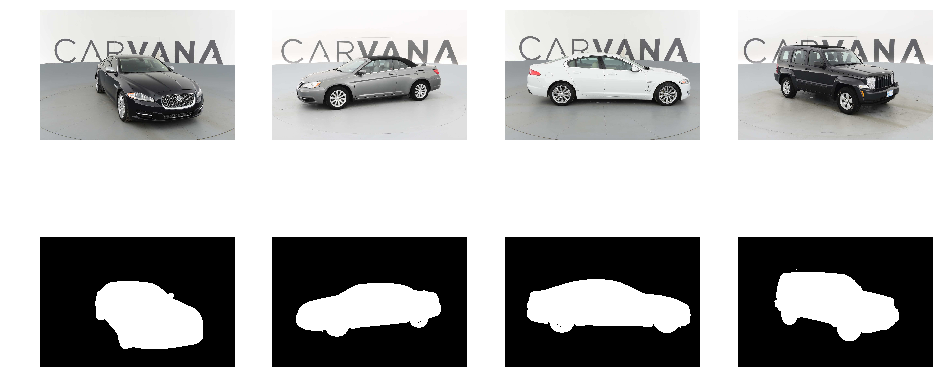

In [25]:
ip.plot(x_train_filenames[:4]+y_train_filenames[:4], count=-1, scale=2.0)

In [0]:
img_shape = (128, 128, 3)
batch_size = 3
epochs = 5

**Processing pathnames**

In [0]:
def _process_pathnames(fpath, lpath):
    img_str= tf.read_file(fpath)
    img= tf.image.decode_jpeg(img_str, channels= 3)
    
    label_img_str= tf.read_file(lpath)
    label_img= tf.image.decode_gif(label_img_str)[0]
    label_img= label_img[:, :, 0]
    #print(label_img.shape)
    label_img= tf.expand_dims(label_img, axis= -1)
    #print(label_img.shape)
    return img, label_img

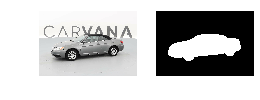

In [29]:
img, limg= _process_pathnames(x_train_filenames[1], y_train_filenames[1])
sess= K.get_session()
img, limg= sess.run((img, limg))
ip.plot([img, np.reshape(limg, (limg.shape[0], limg.shape[1]))])

**Shifting images**

In [0]:
def shift_image(img, limg, width_shift_range, height_shift_range):
    if(width_shift_range or height_shift_range):
        if(width_shift_range):
            width_shift_range= tf.random_uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if(height_shift_range):
            height_shift_range= tf.random_uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
        
        img= tfcontrib.image.translate(img, [width_shift_range, height_shift_range])
        limg= tfcontrib.image.translate(limg, [width_shift_range, height_shift_range])
    return img, limg
        

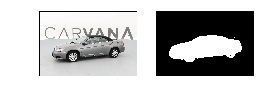

In [31]:
img, limg= shift_image(img, limg, 0.3, .3)
img, limg= sess.run([img, limg])
ip.plot([img, np.reshape(limg, (limg.shape[0], limg.shape[1]))])

**Flipping image randomly**

In [0]:
def flip_img(horizontal_flip, tr_img, label_img):
  if horizontal_flip:
    flip_prob = tf.random_uniform([], 0.0, 1.0)
    tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
  return tr_img, label_img

**Assembling all transformations**

In [0]:
def _augment(img,
             limg,
             resize= None,
             scale= 1.0,
             hue_delta= 0,
             horizontal_flip= False,
             width_shift_range= 0,
             height_shift_range= 0):
    if(resize is not None):
        img= tf.image.resize_images(img, resize)
        limg= tf.image.resize_images(limg, resize)
        
    if(hue_delta):
        img= tf.image.random_hue(img, hue_delta)
       
    img, limg= flip_img(horizontal_flip, img, limg)
    img, limg= shift_image(img, limg, width_shift_range, height_shift_range)
    
    img= tf.to_float(img) * scale
    limg= tf.to_float(img) * scale
    
    return img, limg

In [0]:
def get_baseline_dataset(filenames, 
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5, 
                         batch_size=batch_size,
                         shuffle=True):           
  num_x = len(filenames)
  # Create a dataset from the filenames and labels
  dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
  # Map our preprocessing function to every element in our dataset, taking
  # advantage of multithreading
  dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
  if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
    assert batch_size == 1, "Batching images must be of the same size"

  dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
  
  if shuffle:
    dataset = dataset.shuffle(num_x)
  
  
  # It's necessary to repeat our data for all epochs 
  dataset = dataset.repeat().batch(batch_size)
  return dataset

In [0]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [0]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [37]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames, 
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

W0626 11:02:31.302910 139841542403968 deprecation.py:323] From <ipython-input-33-67cf40c0c886>:19: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


W0626 11:02:41.045269 139841542403968 deprecation.py:323] From <ipython-input-38-461b49cb2dcf>:7: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


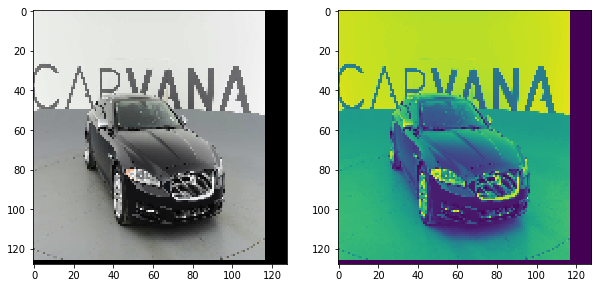

In [38]:
temp_ds = get_baseline_dataset(x_train_filenames, 
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
with tf.Session() as sess: 
  batch_of_imgs, label = sess.run(next_element)

  # Running next element in our graph will produce a batch of images
  plt.figure(figsize=(10, 10))
  img = batch_of_imgs[0]

  plt.subplot(1, 2, 1)
  plt.imshow(img)

  plt.subplot(1, 2, 2)
  plt.imshow(label[0, :, :, 0])
  plt.show()

#### Build the Model

In [0]:
def conv_block(input_tensor, num_filters):
    encoder= keras.layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder= keras.layers.BatchNormalization()(encoder)
    encoder= keras.layers.Activation('relu')(encoder)
    encoder= keras.layers.Conv2D(num_filters, (3, 3), padding= 'same')(encoder)
    encoder= keras.layers.BatchNormalization()(encoder)
    encoder= keras.layers.Activation('relu')(encoder)
    return encoder

In [0]:
def encoder_block(input_tensor, num_filters):
    encoder= conv_block(input_tensor, num_filters)
    encoder_pool= keras.layers.MaxPool2D((2, 2), strides= (2, 2))(encoder)
    return encoder_pool, encoder

In [0]:
def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder= keras.layers.Conv2DTranspose(num_filters, (2, 2), strides= (2, 2), padding= 'same')(input_tensor)
    decoder= keras.layers.concatenate([concat_tensor, decoder], axis= -1)
    decoder= keras.layers.BatchNormalization()(decoder)
    decoder= keras.layers.Activation('relu')(decoder)
    decoder= keras.layers.Conv2D(num_filters, (3, 3), padding= 'same')(decoder)
    decoder= keras.layers.BatchNormalization()(decoder)
    decoder= keras.layers.Activation('relu')(decoder)
    decoder= keras.layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder= keras.layers.BatchNormalization()(decoder)
    decoder= keras.layers.Activation('relu')(decoder)
    return decoder

In [42]:
inputs= keras.layers.Input(shape= img_shape) #256

encoder0_pool, encoder0= encoder_block(inputs, 32)  #128

encoder1_pool, encoder1= encoder_block(encoder0_pool, 64)  #62

encoder2_pool, encoder2= encoder_block(encoder1_pool, 128)  #32

encoder3_pool, encoder3= encoder_block(encoder2_pool, 256)  #16

encoder4_pool, encoder4= encoder_block(encoder3_pool, 512)  #8

center= conv_block(encoder4_pool, 1024) #center

decoder4 = decoder_block(center, encoder4, 512)  # 16

decoder3 = decoder_block(decoder4, encoder3, 256)  # 32

decoder2 = decoder_block(decoder3, encoder2, 128)  # 64

decoder1 = decoder_block(decoder2, encoder1, 64)  # 128

decoder0 = decoder_block(decoder1, encoder0, 32)  # 256

outputs= keras.layers.Conv2D(1, (1, 1), activation= 'sigmoid')(decoder0)

W0626 11:02:41.884344 139841542403968 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
model= keras.models.Model(inputs= [inputs], outputs= [outputs])

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

#### Custom metrics and loss function

In [0]:
def dice_coff(y_true, y_pred):
    smooth= 1.
    
    y_true_f= tf.reshape(y_true, [-1])
    y_pred_f= tf.reshape(y_pred, [-1])
    intersection= tf.reduce_sum(y_true_f* y_pred_f)
    score= (2. * intersection + smooth)/ (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

In [0]:
def dice_loss(y_true, y_pred):
    loss= 1- dice_coff(y_true, y_pred)
    return loss

In [0]:
def bce_dice_loss(y_true, y_pred):
    loss= keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

**Compile the model**

In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

model.summary()

#### Train the model

In [0]:
save_model_path = '/tmp/weights.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)

In [55]:
int(np.ceil(num_val_examples / float(batch_size)))

67

In [56]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=2,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))))

Epoch 1/2


InvalidArgumentError: ignored

In [54]:
history = model.fit(train_ds, 
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[cp])

Epoch 1/5


KeyboardInterrupt: ignored

In [0]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()